## Import libraries

In [46]:
import pandas as pd
import numpy as np

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
import string


from tqdm import tqdm
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

## Import dataset

In [6]:
train = pd.read_csv("dataset/jigsaw-toxic-comment-train.csv")

## Delete unused columns

In [7]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

## Display new data

In [7]:
train.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


## Analyze wods frequences function defenition

In [8]:
def get_top_n_most_common_words(toxic_value: int, n: int, df: pd.DataFrame, column: str) -> list:
    if toxic_value == 2:
        words = df[column].apply(lambda text: [word.lower() for word in text.split()])
    else:
        words = df[df.toxic == toxic_value][column].apply(lambda text: [word.lower() for word in text.split()])
    counted_words = Counter()
    for word in words:
        counted_words.update(word)
    return counted_words.most_common(n)

## Plot words frequences

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.31s/it]


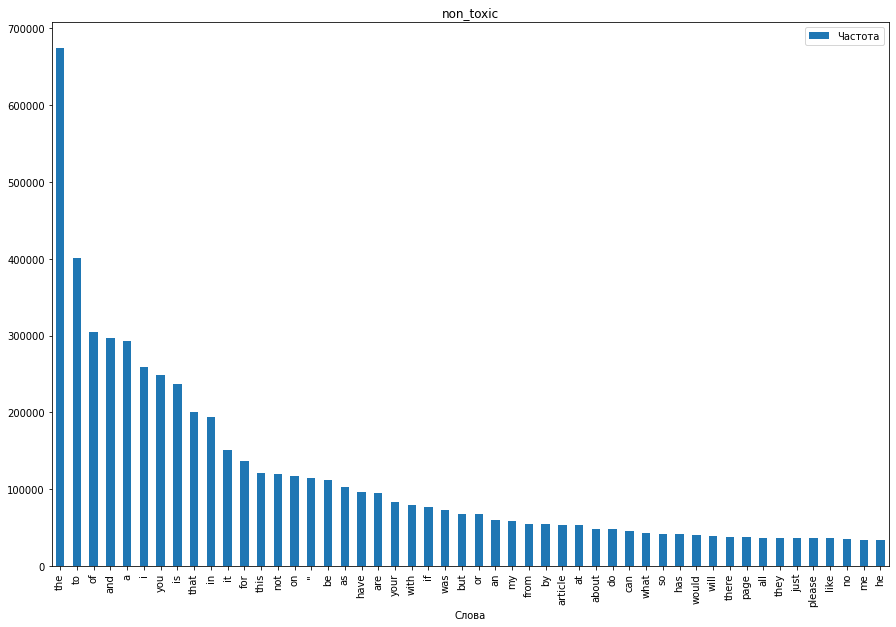

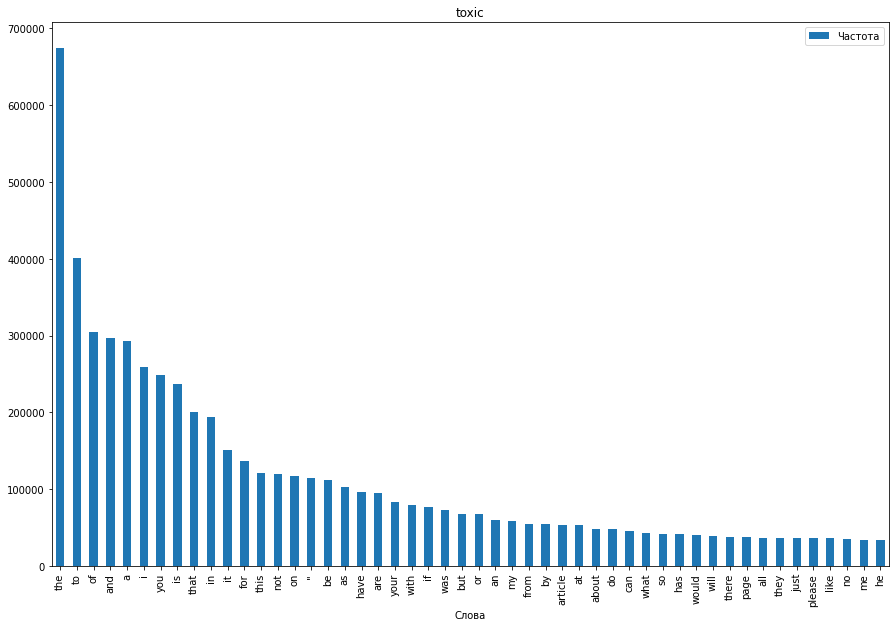

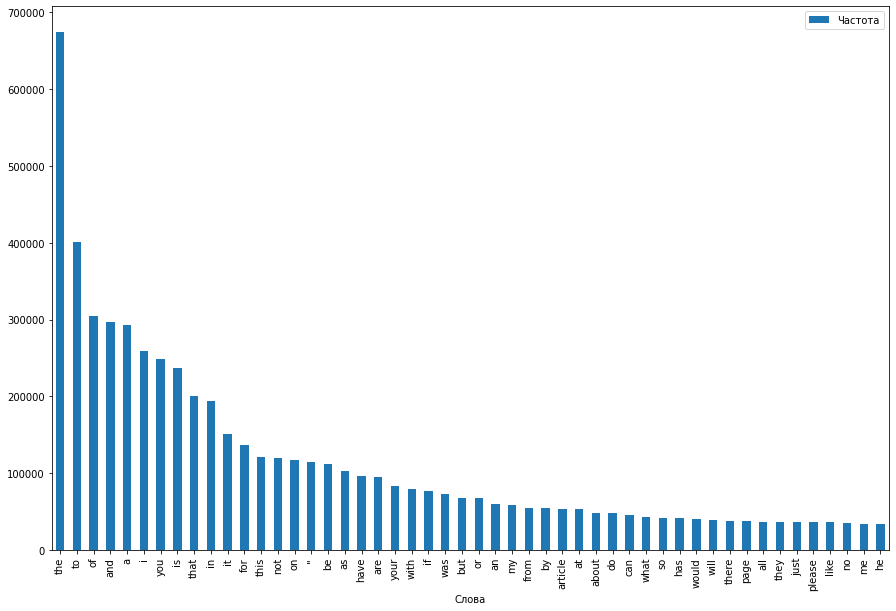

In [15]:
labels = ['non_toxic', 'toxic', '']

for i in tqdm(range(3)):
    top_common_words = get_top_n_most_common_words(i, 30, train, "comment_text")
    top_common_words_df = pd.DataFrame(top_50_common_words, columns=['Слова', 'Частота'])
    top_common_words_df.plot(kind='bar', x='Слова', figsize=(15,10), title=labels[i])

## Remove stop words and add lemmatization (text cleaning). Update: lemmatization is barely effective and takes 12 mins on dataset

In [9]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def text_process(mess):
    STOPWORDS = stopwords.words('english')
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in STOPWORDS])
    #lemmatizer = WordNetLemmatizer()
    #tokens = [word for word in nopunc.split() if word.lower() not in STOPWORDS]
    #tagged_tokens = pos_tag(tokens)
    #lemmatized = ' '.join([lemmatizer.lemmatize(token[0], get_wordnet_pos(token[1])) for token in tagged_tokens])
    #return lemmatized

## Apply text cleaning

In [10]:
tqdm.pandas()

train['clean_comment_text'] = train.comment_text.progress_apply(text_process)

100%|████████████████████████████████████████████████████████████████████████| 223549/223549 [01:14<00:00, 2987.70it/s]


In [63]:
train.head()

,id,comment_text,toxic,clean_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,daww matches background colour im seemingly st...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,hey man im really trying edit war guy constant...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,cant make real suggestions improvement wondere...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page thats


## Plot words frequences without stopwords and lemmatized

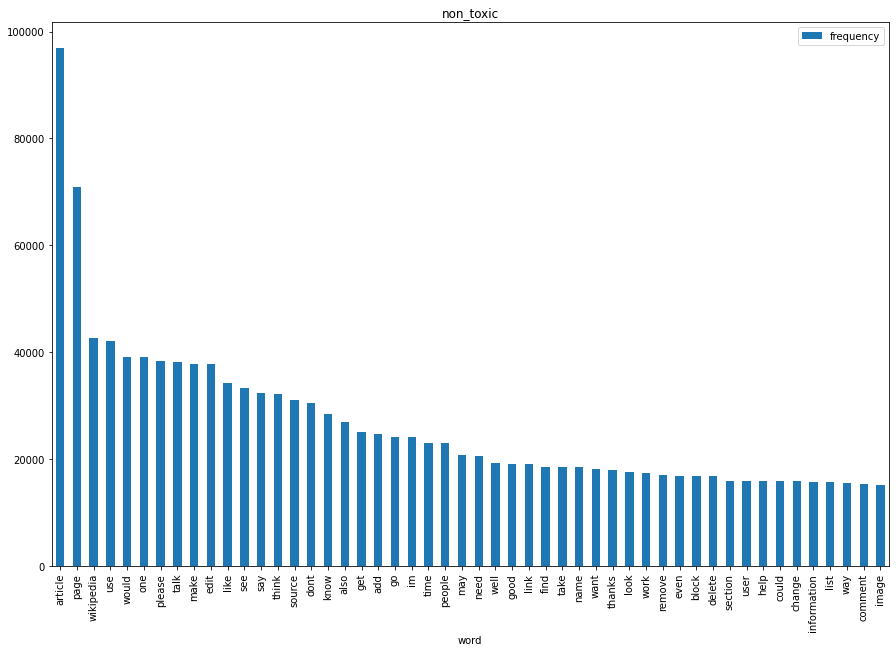

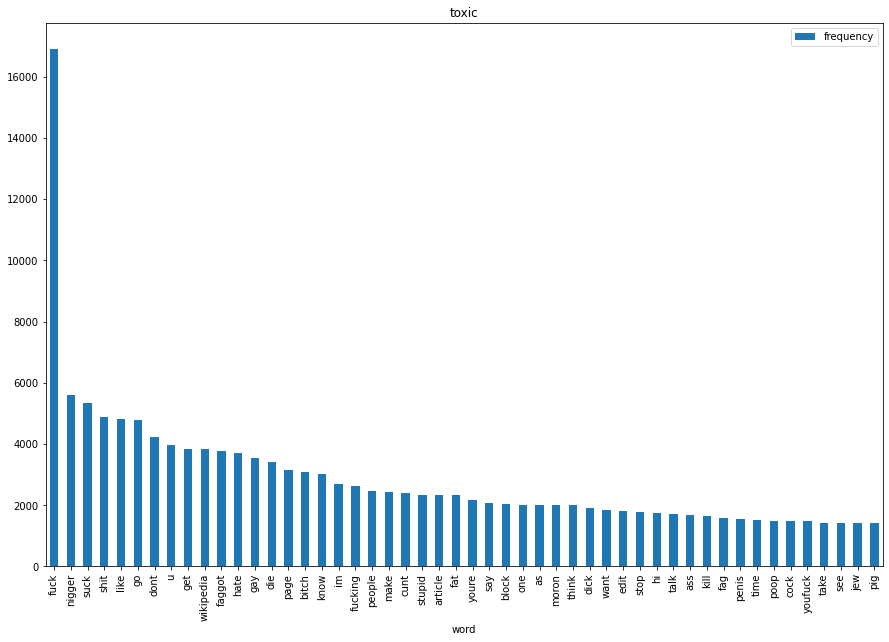

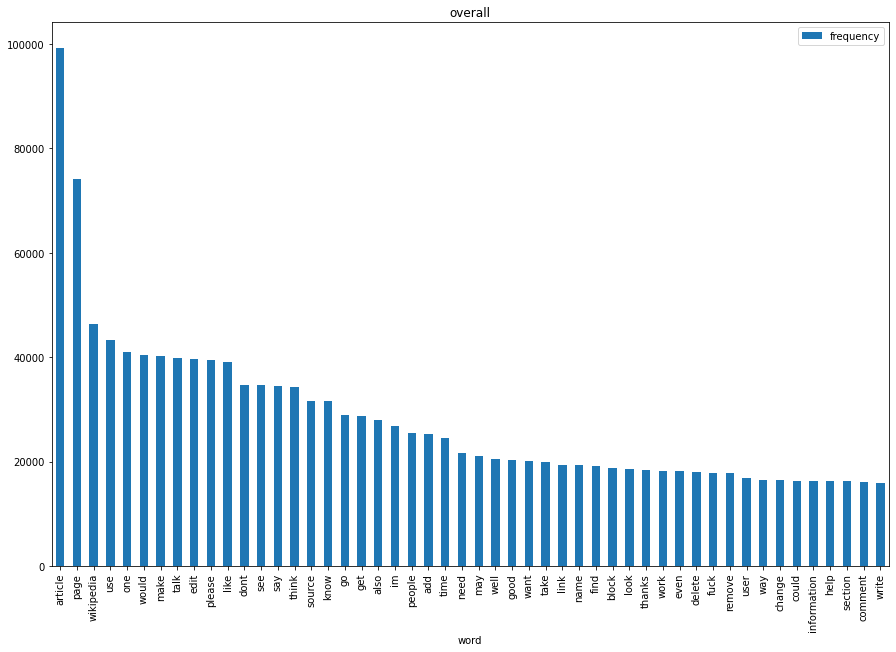

In [79]:
labels = ['non_toxic', 'toxic', 'overall']

for i in range(3):
    top_50_common_words = get_top_n_most_common_words(i, 50, train, "clean_comment_text")
    top_50_common_words_df = pd.DataFrame(top_50_common_words, columns=['word', 'frequency'])
    top_50_common_words_df.plot(kind='bar', x='word', figsize=(15,10), title=labels[i])

## Metrics and vizualization

In [70]:
def plot_confusion_matrix1(y, y_hat, labels):
    cm = metrics.confusion_matrix(y, y_hat)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cmn, index = [i for i in ["Not Toxic", "Toxic"]],
                  columns = [i for i in ["Not Toxic", "Toxic"]])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

In [26]:
def plot_roc(y, y_hat, label):
    auc = metrics.roc_auc_score(y, y_hat)
    fpr, tpr, _ = metrics.roc_curve(y, y_hat)
    plt.plot(fpr,tpr,label="{0}, auc={1}".format(label, auc))
    plt.xlabel("False Pasitive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show() 

## Apply cross-validation

In [27]:
x_train, x_test, y_train, y_test = train_test_split(train.clean_comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)
print (x_train.shape)
print (x_test.shape)

(178839,)
(44710,)


## Vectorization (BOW with TF-IDF)

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), token_pattern=r'\w{1,}',
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
x_train_term_doc = vectorizer.fit_transform(x_train)

# Didn't fit and transform because we want to use the same vocabulary from training set
x_test_term_doc = vectorizer.transform(x_test)

## Logistic regression

In [29]:
lr = LogisticRegression(max_iter=1000, random_state=0, C=4)
%time lr.fit(x_train_term_doc, y_train)

Wall time: 17.2 s


LogisticRegression(C=4, max_iter=1000, random_state=0)

In [30]:
y_hat_lr = lr.predict(x_test_term_doc)

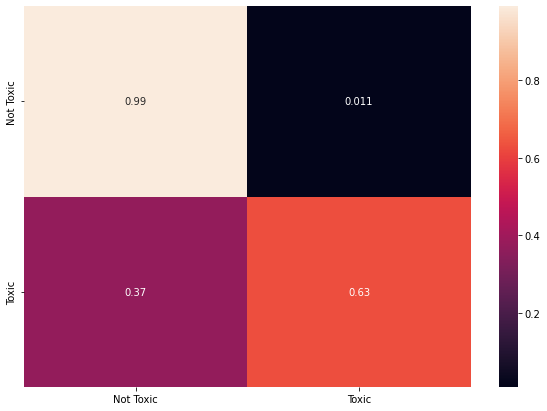

In [31]:
plot_confusion_matrix(y_test, y_hat_lr, labels=["Toxic", "Not Toxic"])

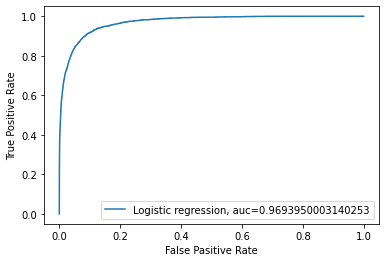

Accuracy:  0.954529188101096


In [33]:
y_hat_lr_proba = lr.predict_proba(x_test_term_doc)[::,1]

plot_roc(y_test, y_hat_lr_proba, "Logistic regression")
print("Accuracy: ", accuracy_score(y_test, y_hat_lr))

In [48]:
print("Precision: ", precision_score(y_test, y_hat_lr))
print("Recall: ", recall_score(y_test, y_hat_lr))

Precision:  0.8586956521739131
Recall:  0.6280102875847556


## Multinomial  Naive Bayes

In [34]:
mnb = MultinomialNB()
%time mnb.fit(x_train_term_doc, y_train)
y_hat_mnb = mnb.predict(x_test_term_doc)

Wall time: 120 ms


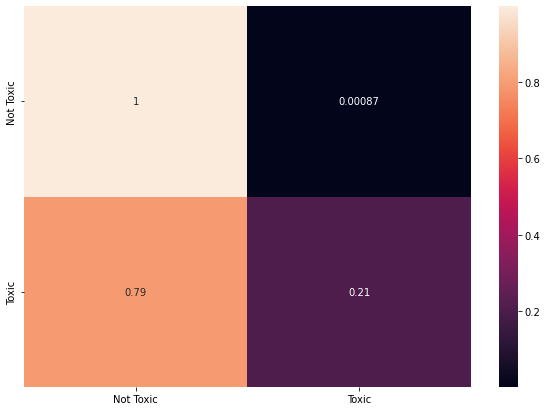

In [36]:
plot_confusion_matrix(y_test, y_hat_mnb, labels=["Toxic", "Not Toxic"])

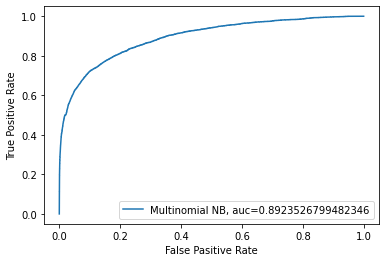

Accuracy:  0.9233057481547752


In [37]:
y_hat_mnb_proba = mnb.predict_proba(x_test_term_doc)[::,1]

plot_roc(y_test, y_hat_mnb_proba, "Multinomial NB")
print("Accuracy: ", accuracy_score(y_test, y_hat_mnb))

In [60]:
print("Precision: ", precision_score(y_test, y_hat_mnb))
print("Recall: ", recall_score(y_test, y_hat_mnb))

Precision:  0.9618736383442266
Recall:  0.20645312134673838


So far classic logistic regression is more precise than Naive Bayes Classifier

## Neural networks

## 1.Simple RNN

In [39]:
# Done to accelerate learning speed at the expence of accuracy
train_nn = train.loc[:12000,:]
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(train_nn.clean_comment_text.values, train_nn.toxic.values, 
                                                  stratify=train_nn.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)
print (x_train_nn.shape)
print (x_test_nn.shape)

(9600,)
(2401,)


In [40]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

In [41]:
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(x_train_nn) + list(x_test_nn))
x_train_nn_seq = token.texts_to_sequences(x_train_nn)
x_test_nn_seq = token.texts_to_sequences(x_test_nn)

#zero pad the sequences
x_train_nn_pad = sequence.pad_sequences(x_train_nn_seq, maxlen=max_len)
x_test_nn_pad = sequence.pad_sequences(x_test_nn_seq, maxlen=max_len)

word_index = token.word_index

In [11]:
len(word_index)

361587

In [42]:
%%time
with strategy.scope():
    model_rnn = Sequential()
    model_rnn.add(Embedding(len(word_index) + 1, 300, input_length=max_len))
    model_rnn.add(SimpleRNN(100))
    model_rnn.add(Dense(1, activation='sigmoid'))
    model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model_rnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1500, 300)         14278200  
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 100)               40100     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 14,318,401
Trainable params: 14,318,401
Non-trainable params: 0
_________________________________________________________________
Wall time: 465 ms


In [24]:
import visualkeras
visualkeras.layered_view(model_rnn)

TypeError: 'int' object is not iterable

In [43]:
model_rnn.fit(x_train_nn_pad, y_train_nn, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
150/150 [==============================] - 163s 1s/step - loss: 0.2980 - accuracy: 0.9043
Epoch 2/5
150/150 [==============================] - 209s 1s/step - loss: 0.3054 - accuracy: 0.8644
Epoch 3/5
150/150 [==============================] - 187s 1s/step - loss: 0.2612 - accuracy: 0.9443
Epoch 4/5
150/150 [==============================] - 214s 1s/step - loss: 0.1456 - accuracy: 0.9649
Epoch 5/5
150/150 [==============================] - 207s 1s/step - loss: 0.1050 - accuracy: 0.9700


In [66]:
y_hat_rnn_proba = model_rnn.predict(x_test_nn_pad)

In [67]:
y_hat_rnn =np.round(abs(y_hat_rnn_proba))

In [68]:
y_hat_rnn

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [64]:
y_test_nn

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

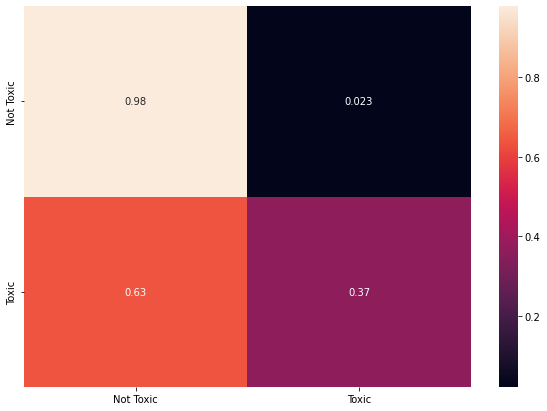

In [71]:
plot_confusion_matrix1(y_test_nn, y_hat_rnn, "Simple RNN")

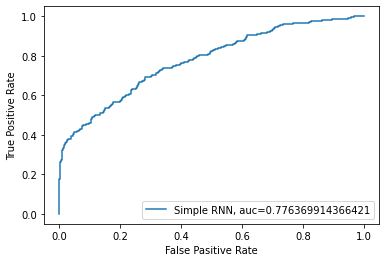

Accuracy:  0.9196168263223656


In [74]:
plot_roc(y_test_nn, y_hat_rnn_proba, "Simple RNN")
print("Accuracy: ", accuracy_score(y_test_nn, y_hat_rnn))

In [15]:
model_rnn.save('model_rnn_seq')

INFO:tensorflow:Assets written to: model_rnn_seq\assets


In [17]:
import pickle

pickle.dump(model_rnn, open('model_rnn.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://bcf3d327-7554-4d05-b5e2-ec62bedad954/assets


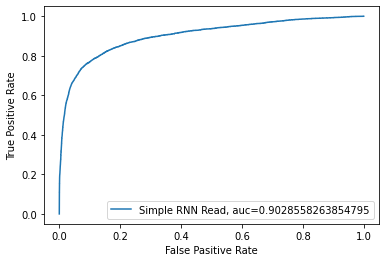

In [27]:
read_model = tf.keras.models.load_model('model_rnn_seq')
y_hat_rnn_proba_read = read_model.predict(x_test_nn_pad)


In [52]:
plot_roc(y_test_nn, y_hat_rnn_proba_read, "Simple RNN")

NameError: name 'y_hat_rnn_proba_read' is not defined

In [30]:
print("Accuracy: ", accuracy_score(y_test_nn, y_hat_rnn_proba_read.round()))

Accuracy:  0.934690225900246


## 2. RNN with word embedding (word2vec) (Not done yet)

In [77]:
from gensim.models import KeyedVectors 
from gensim.models import Word2Vec 
import gensim.downloader as api

%time word2vec_model = api.load('word2vec-google-news-300')

Wall time: 40.3 s


## Word2vec small demo

In [90]:
print(word2vec_model.similarity('cat', 'dog'))
print(word2vec_model.similarity('cat', 'cats'))
print(word2vec_model.similarity('Amsterdam', 'Holland'))
print(word2vec_model.similarity('queen', 'king'))

0.76094574
0.8099379
0.5121847
0.6510956


In [118]:
tqdm.pandas()

def get_average_vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)    
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_embeddings(vectors, text, generate_missing=False, k=300):
    embeddings = np.array([get_average_vec(x, vectors, generate_missing=generate_missing, k=k) for x in text])
    return embeddings

In [122]:
%time embeddings_word2vec = get_embeddings(word2vec_model, x_train_nn, k=300)

Wall time: 6.38 s


## TODO: Create model with word2vec or Glove

In [126]:
%%time
with strategy.scope():
    model_w2v = Sequential()
    model_w2v.add(Embedding(12000, 300, weights=[embeddings_word2vec], input_length=max_len,  trainable=False))
    model_w2v.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model_w2v.add(Dense(1, activation='sigmoid'))
    model_w2v.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model_w2v.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 1500, 300)         3600000   
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,760,501
Trainable params: 160,501
Non-trainable params: 3,600,000
_________________________________________________________________
Wall time: 552 ms


In [131]:
x_train_nn.shape

(12000,)

In [132]:
y_train_nn.shape

(12000,)

## Final

In [75]:
train = pd.read_csv("dataset/jigsaw-toxic-comment-train.csv")
validation = pd.read_csv('dataset/validation.csv')
test = pd.read_csv('dataset/test.csv')

In [76]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [77]:
train = train.loc[:12000,:]
train.shape

(12001, 3)

In [78]:
train['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

In [79]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [80]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [81]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [82]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1500, 300)         13049100  
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 100)               40100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 13,089,301
Trainable params: 13,089,301
Non-trainable params: 0
_________________________________________________________________
Wall time: 201 ms


In [83]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
150/150 [==============================] - 162s 1s/step - loss: 0.3083 - accuracy: 0.9026
Epoch 2/5
150/150 [==============================] - 192s 1s/step - loss: 0.1758 - accuracy: 0.9302
Epoch 3/5
150/150 [==============================] - 231s 2s/step - loss: 0.0378 - accuracy: 0.9895
Epoch 4/5
150/150 [==============================] - 189s 1s/step - loss: 0.0050 - accuracy: 0.9997
Epoch 5/5
150/150 [==============================] - 229s 2s/step - loss: 0.0016 - accuracy: 1.0000


In [85]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.81%


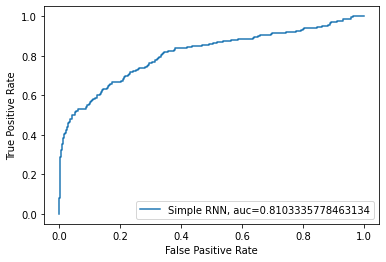

In [86]:
plot_roc(yvalid, scores, "Simple RNN")

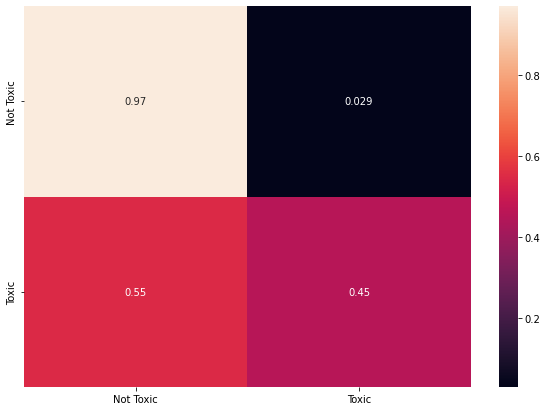

In [87]:
plot_confusion_matrix1(yvalid, np.round(abs(scores)), labels=["Toxic", "Not Toxic"])

In [88]:
print("Accuracy: ", accuracy_score(yvalid, np.round(abs(scores))))

Accuracy:  0.9221157850895461


In [89]:
print("Precision: ", precision_score(yvalid, np.round(abs(scores))))
print("Recall: ", recall_score(yvalid, np.round(abs(scores))))

Precision:  0.6204819277108434
Recall:  0.45374449339207046


In [26]:
embeddings_index = {}
f = open('dataset/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [08:37, 4239.45it/s]

Found 2196017 word vectors.


In [34]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|█████████████████████████████████████████████████████████████████████████| 43496/43496 [00:03<00:00, 12856.64it/s]


In [35]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model2 = Sequential()
    model2.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model2.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model2.add(Dense(1, activation='sigmoid'))
    model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1500, 300)         13049100  
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 13,209,601
Trainable params: 160,501
Non-trainable params: 13,049,100
_________________________________________________________________
Wall time: 260 ms


In [38]:
 scores = model.evaluate(xtrain_pad, ytrain, batch_size = 64)


150/150 [==============================] - 57s 376ms/step - loss: 0.0046 - accuracy: 0.9998


In [39]:
scores

[0.004551942925900221, 0.99979168176651]

In [ ]:
scores2 = model2.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores2,yvalid)))

In [ ]:
plot_roc(yvalid, scores2, "LSTM")

In [ ]:
plot_confusion_matrix(yvalid, np.round(abs(scores2)), labels=["Toxic", "Not Toxic"])

In [ ]:
print("Accuracy: ", accuracy_score(yvalid, np.round(abs(scores2))))